In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display

# Data

In [78]:
base = './drive/MyDrive/DSH/Lafan Repo'
metrics = pd.read_csv(f"{base}/metrics.csv")
metrics['Dataset'] = [' '.join(m.split('_')[:2]).split('/')[-1] for m in metrics.BVH]
metrics = metrics[['Dataset', 'Wall-Clock Elapsed Time (s)', 'Node Sequence', 'Steps', 'Start Node',	'End Node',	'Error']].set_index('Dataset')
print(metrics.shape)
metrics.head()

(240, 6)


,Wall-Clock Elapsed Time (s),Node Sequence,Steps,Start Node,End Node,Error
Dataset,,,,,,
lafan 5,2.922619,"[4214, 4215, 4216, 4217, 4218, 4220]",5,4214,8045,NaN
lafan 5,2.713102,"[10606, 10607, 10608, 10609, 10610, 10612]",5,10606,9312,NaN
lafan 5,1.860216,"[2324, 2325, 2326, 2327, 2328, 2330]",5,2324,8330,NaN
lafan 5,3.204036,"[684, 685, 686, 687, 688, 690]",5,684,6265,NaN
lafan 5,2.811616,"[6733, 6734, 6735, 6736, 6737, 6739]",5,6733,6922,NaN


In [79]:
max_time = round(max(metrics['Wall-Clock Elapsed Time (s)'])/10)*10
df_cols = ['dataset', 'difference threshold', 'steps', 'mean', 'standard deviation']
digits = 2

In [80]:
metrics['# Nodes'] = [len(seq[1:-1].split(', ')) for seq in metrics['Node Sequence']]
early_termination = [steps + 1 != num_nodes for steps, num_nodes in zip(metrics.Steps, metrics['# Nodes'])]
print(sum(early_termination), 'terminated early')
print(Counter(metrics[early_termination].index))
metrics[early_termination][['Steps', '# Nodes']]

43 terminated early
Counter({'cmu 1K': 13, 'cmu 10K': 13, 'cmu 5': 8, 'lafan 10000': 7, 'lafan 5': 1, 'lafan 1000': 1})


,Steps,# Nodes
Dataset,,
lafan 10000,20,18
lafan 10000,20,17
lafan 10000,40,32
lafan 10000,40,8
cmu 5,5,5
cmu 5,20,4
cmu 5,20,1
cmu 5,40,2
cmu 5,40,22


In [81]:
metadata_pth = f'{base}/dataset metadata'
datasets_meta = {
    'lafan': {
        '5': pd.read_csv(f"{metadata_pth}/lafan_5.csv").set_index('node_id'),
        '1k': pd.read_csv(f"{metadata_pth}/lafan_1000.csv").set_index('node_id'),
        '10k': pd.read_csv(f"{metadata_pth}/lafan_10000.csv").set_index('node_id'),
    },
    'cmu': {
        '5': pd.read_csv(f"{metadata_pth}/cmu_5.csv").set_index('node_id'),
        '1k': pd.read_csv(f"{metadata_pth}/cmu_1K.csv").set_index('node_id'),
        '10k': pd.read_csv(f"{metadata_pth}/cmu_10K.csv").set_index('node_id'),
    },
}

In [82]:
datasets = {
    'lafan': {
        'all': metrics[['lafan' in ds for ds in metrics.index]],
        '5': metrics[['lafan 5' == ds for ds in metrics.index]],
        '1k': metrics[['lafan 1000' == ds for ds in metrics.index]],
        '10k': metrics[['lafan 10000' == ds for ds in metrics.index]],
    },
    'cmu': {
        'all': metrics[['cmu' in ds for ds in metrics.index]],
        '5': metrics[['cmu 5' == ds for ds in metrics.index]],
        '1k': metrics[['cmu 1K' == ds for ds in metrics.index]],
        '10k': metrics[['cmu 10K' == ds for ds in metrics.index]],
    },
}
graph_line_settings = {
  'lafan all': 'red',
  'lafan 5': 'mistyrose',
  'lafan 1k': 'lightcoral',
  'lafan 10k': 'darkred',
  'cmu all': 'blue',
  'cmu 5': 'lightcyan',
  'cmu 1k': 'lightblue',
  'cmu 10k': 'steelblue'
}

# Utilities

In [83]:
def ngram(elem_lst, n=1):
  ngram_lst = []
  for i in range(0, len(elem_lst)-n+1):
    ngram_lst.append(tuple(elem_lst[i:i+n]))
  return ngram_lst

In [84]:
def clips(seq, metadata):
  clips = []
  if len(seq) > 0:
    seq[0] = int(seq[0])
    seq0_data = metadata.loc[[seq[0]]]

    curr_clip = [seq[0]]
    last_idx = int(seq0_data['motion_idx'])
    last_frame = int(seq0_data['frame_end'])

    for node in seq[1:]:
      node = int(node)
      node_data = metadata.loc[[node]]

      curr_idx = int(node_data['motion_idx'])
      start_frame = int(node_data['frame_start'])

      if last_frame == start_frame and last_idx == curr_idx:
        curr_clip.append(node)
      else:
        clips.append(curr_clip)
        curr_clip = [node]

      last_frame = int(node_data['frame_end'])
      last_idx = curr_idx
      
    clips.append(curr_clip)
  return clips


In [85]:
def mean_std(by_steps):
  return [np.mean(steps) for steps in by_steps], [np.std(steps) for steps in by_steps]

In [86]:
def natural(by_steps, n=4):
  n_lst = [[[ngram(trial[1:-1].split(', '), n=i) for i in range(1,n+1)] for trial in node_seq] for node_seq in by_steps]
  p_lst = [[[len(set(seq))/len(seq) if len(seq) > 0 else 0 for seq in trial] for trial in node_n] for node_n in n_lst]
  bleu_nat_lst = [[np.exp(np.sum([(1/n)*np.log(p) for p in trial])) for trial in node_p] for node_p in p_lst]
  return bleu_nat_lst

In [87]:
# prints for debugging
def novel(by_steps, metadata):
  n_clips_lst = []
  total_nodes_lst = []
  # print(by_steps)
  for node_seq in by_steps:
    # print(node_seq)
    n_clips_lst_step = []
    total_nodes_lst_step = []
    for seq in node_seq:
      # print(seq)
      seq = seq[1:-1].split(', ')
      clips_lst = clips(seq, metadata)
      # print(clips_lst)
      n_clips_lst_step.append(len(clips_lst))
      total_nodes_lst_step.append(len(seq))
      # print(len(clips_lst), len(seq))
    n_clips_lst.append(n_clips_lst_step)
    total_nodes_lst.append(total_nodes_lst_step)
  # print(n_clips_lst)
  # print(total_nodes_lst)
  bleu_nov_lst = [[clips/total  if total > 0 else 0  for clips, total in zip(clip_step, total_step)] for clip_step, total_step in zip(n_clips_lst, total_nodes_lst)]
  return bleu_nov_lst

In [88]:
dataset='lafan'
dataset_diff='5'
df = datasets[dataset][dataset_diff]
df_meta = datasets_meta[dataset][dataset_diff]
# remove those that terminated early
df_completed = df[df['# Nodes'] == 1+df['Steps']]

print(f'{dataset} {dataset_diff}: {df.shape[0]} trials, {df.shape[0]-df_completed.shape[0]} ended early')

df_seq_by_steps = df_completed.groupby('Steps')['Node Sequence'].apply(list)
all_steps = df_seq_by_steps.index

novel_lst = novel(df_seq_by_steps, df_meta)

mu, sigma = mean_std(novel_lst)
for step, single_mu, single_sigma in zip(all_steps, mu, sigma):
  print(f'> > {step} steps:')
  print(f'> > > mean: {round(single_mu, digits)}')
  print(f'> > > standard deviation: {round(single_sigma, digits)}')

lafan 5: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 0.33
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 0.18
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 0.1
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 0.05
> > > standard deviation: 0.0


# Metrics

## Amount Completed

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


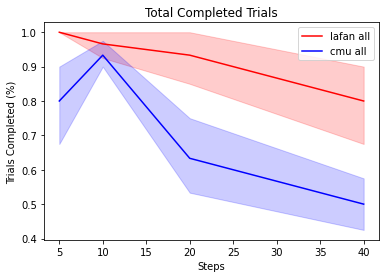

In [99]:
lafan_x = []
lafan_y = []

cmu_x = []
cmu_y = []

for dataset in datasets:
  for dataset_diff in datasets[dataset]:
    df = datasets[dataset][dataset_diff]
    df_completed = df[df['# Nodes'] == 1+df['Steps']]

    total_steps = df.groupby('Steps')['# Nodes'].count()
    completed_steps = df_completed.groupby('Steps')['# Nodes'].count()

    for step, count, total in zip(completed_steps.index, completed_steps, total_steps):
      percent = count / total
      if dataset == 'lafan':
        lafan_x.append(step)
        lafan_y.append(percent)
      elif dataset == 'cmu':
        cmu_x.append(step)
        cmu_y.append(percent)

label = f'lafan all'
sns.lineplot(lafan_x, lafan_y, label=label, 
              color=graph_line_settings[label])
label = f'cmu all'
sns.lineplot(cmu_x, cmu_y, label=label, 
              color=graph_line_settings[label])

plt.title('Total Completed Trials')
plt.xlabel('Steps')
plt.ylabel('Trials Completed (%)');

# Speed
I ran these on my personal computer.

In [90]:
speed_df_info = {}
for col in df_cols:
  speed_df_info[col] = []

for dataset in datasets:
  for dataset_diff in datasets[dataset]:
    df = datasets[dataset][dataset_diff]
    # remove those that terminated early
    df_completed = df[df['# Nodes'] == 1+df['Steps']]

    print(f'{dataset} {dataset_diff}: {df.shape[0]} trials, {df.shape[0]-df_completed.shape[0]} ended early')

    df_elapsed_by_steps = df_completed.groupby('Steps')['Wall-Clock Elapsed Time (s)'].apply(list)
    all_steps = df_elapsed_by_steps.index

    mu, sigma = mean_std(df_elapsed_by_steps)

    for step, single_mu, single_sigma in zip(all_steps, mu, sigma):
      speed_df_info['dataset'].append(dataset)
      speed_df_info['difference threshold'].append(dataset_diff)
      speed_df_info['steps'].append(step)
      speed_df_info['mean'].append(single_mu)
      speed_df_info['standard deviation'].append(single_sigma)

      print(f'> > {step} steps:')
      print(f'> > > mean: {round(single_mu, digits)}')
      print(f'> > > standard deviation: {round(single_sigma, digits)}')

    print()
  print('\n\n')

lafan all: 120 trials, 9 ended early
> > 5 steps:
> > > mean: 2.99
> > > standard deviation: 0.62
> > 10 steps:
> > > mean: 6.78
> > > standard deviation: 2.08
> > 20 steps:
> > > mean: 15.3
> > > standard deviation: 3.47
> > 40 steps:
> > > mean: 32.65
> > > standard deviation: 4.39

lafan 5: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 2.87
> > > standard deviation: 0.48
> > 10 steps:
> > > mean: 5.95
> > > standard deviation: 1.86
> > 20 steps:
> > > mean: 17.35
> > > standard deviation: 2.51
> > 40 steps:
> > > mean: 33.02
> > > standard deviation: 2.57

lafan 1k: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 3.15
> > > standard deviation: 0.68
> > 10 steps:
> > > mean: 7.28
> > > standard deviation: 2.33
> > 20 steps:
> > > mean: 15.42
> > > standard deviation: 3.55
> > 40 steps:
> > > mean: 32.21
> > > standard deviation: 6.15

lafan 10k: 40 trials, 7 ended early
> > 5 steps:
> > > mean: 2.98
> > > standard deviation: 0.68
> > 10 steps:
> > > mean: 6.98
> > > standard de

In [91]:
speed_summary = pd.DataFrame.from_dict(speed_df_info)
speed_summary.head()

,dataset,difference threshold,steps,mean,standard deviation
0,lafan,all,5,2.992146,0.624846
1,lafan,all,10,6.784361,2.077123
2,lafan,all,20,15.299293,3.474252
3,lafan,all,40,32.648612,4.386080
4,lafan,5,5,2.871856,0.477900


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


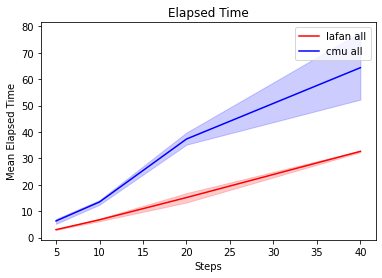

In [92]:
lafan_x = []
lafan_y = []

cmu_x = []
cmu_y = []

for _, row in speed_summary.iterrows():
  if row['dataset'] == 'lafan':
    lafan_x.append(row['steps'])
    lafan_y.append(row['mean'])
  if row['dataset'] == 'cmu':
    cmu_x.append(row['steps'])
    cmu_y.append(row['mean'])

label = f'lafan all'
sns.lineplot(lafan_x, lafan_y, label=label, 
              color=graph_line_settings[label])
label = f'cmu all'
sns.lineplot(cmu_x, cmu_y, label=label, 
              color=graph_line_settings[label])

plt.title('Elapsed Time')
plt.xlabel('Steps')
plt.ylabel('Mean Elapsed Time');

# Naturalness

In [93]:
naturalness_df_info = {}
for col in df_cols:
  naturalness_df_info[col] = []

for dataset in datasets:
  for dataset_diff in datasets[dataset]:
    if dataset_diff != 'all':
      df = datasets[dataset][dataset_diff]
      # remove those that terminated early
      df_completed = df[df['# Nodes'] == 1+df['Steps']]

      print(f'{dataset} {dataset_diff}: {df.shape[0]} trials, {df.shape[0]-df_completed.shape[0]} ended early')
      
      df_seq_by_steps = df_completed.groupby('Steps')['Node Sequence'].apply(list)
      all_steps = df_seq_by_steps.index

      natural_lst = natural(df_seq_by_steps, n=4)

      mu, sigma = mean_std(natural_lst)
      for step, single_mu, single_sigma in zip(all_steps, mu, sigma):
        naturalness_df_info['dataset'].append(dataset)
        naturalness_df_info['difference threshold'].append(dataset_diff)
        naturalness_df_info['steps'].append(step)
        naturalness_df_info['mean'].append(single_mu)
        naturalness_df_info['standard deviation'].append(single_sigma)

        print(f'> > {step} steps:')
        print(f'> > > mean: {round(single_mu, digits)}')
        print(f'> > > standard deviation: {round(single_sigma, digits)}')
      
    print()
  print('\n\n')


lafan 5: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 1.0
> > > standard deviation: 0.0

lafan 1k: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 1.0
> > > standard deviation: 0.0

lafan 10k: 40 trials, 7 ended early
> > 5 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 1.0
> > > standard deviation: 0.0





cmu 5: 40 trials, 8 ended early
> > 5 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 1.0
> > > standard deviation: 0.0
> > 20 steps:
> > >

In [94]:
naturalness_summary = pd.DataFrame.from_dict(naturalness_df_info)
naturalness_summary.head()

,dataset,difference threshold,steps,mean,standard deviation
0,lafan,5,5,1.0,0.0
1,lafan,5,10,1.0,0.0
2,lafan,5,20,1.0,0.0
3,lafan,5,40,1.0,0.0
4,lafan,1k,5,1.0,0.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


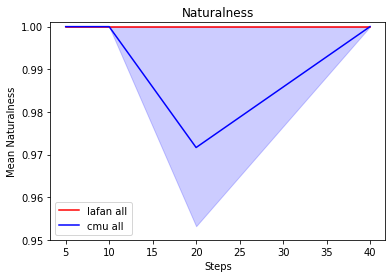

In [95]:
lafan_x = []
lafan_y = []

cmu_x = []
cmu_y = []

for _, row in naturalness_summary.iterrows():
  if row['dataset'] == 'lafan':
    lafan_x.append(row['steps'])
    lafan_y.append(row['mean'])
  if row['dataset'] == 'cmu':
    cmu_x.append(row['steps'])
    cmu_y.append(row['mean'])

label = f'lafan all'
sns.lineplot(lafan_x, lafan_y, label=label, 
              color=graph_line_settings[label])
label = f'cmu all'
sns.lineplot(cmu_x, cmu_y, label=label, 
              color=graph_line_settings[label])

plt.ylim(0.95, 1.001);
plt.title('Naturalness')
plt.xlabel('Steps')
plt.ylabel('Mean Naturalness');

# Novelty

In [96]:
novelty_df_info = {}
for col in df_cols:
  novelty_df_info[col] = []

for dataset in datasets:
  for dataset_diff in datasets[dataset]:
    if dataset_diff != 'all':
      df = datasets[dataset][dataset_diff]
      df_meta = datasets_meta[dataset][dataset_diff]
      # remove those that terminated early
      df_completed = df[df['# Nodes'] == 1+df['Steps']]

      print(f'{dataset} {dataset_diff}: {df.shape[0]} trials, {df.shape[0]-df_completed.shape[0]} ended early')
      
      df_seq_by_steps = df_completed.groupby('Steps')['Node Sequence'].apply(list)
      all_steps = df_seq_by_steps.index

      novel_lst = novel(df_seq_by_steps, df_meta)

      mu, sigma = mean_std(novel_lst)
      for step, single_mu, single_sigma in zip(all_steps, mu, sigma):
        novelty_df_info['dataset'].append(dataset)
        novelty_df_info['difference threshold'].append(dataset_diff)
        novelty_df_info['steps'].append(step)
        novelty_df_info['mean'].append(single_mu)
        novelty_df_info['standard deviation'].append(single_sigma)

        print(f'> > {step} steps:')
        print(f'> > > mean: {round(single_mu, digits)}')
        print(f'> > > standard deviation: {round(single_sigma, digits)}')
    print()
  print('\n\n')


lafan 5: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 0.33
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 0.18
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 0.1
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 0.05
> > > standard deviation: 0.0

lafan 1k: 40 trials, 1 ended early
> > 5 steps:
> > > mean: 0.33
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 0.18
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 0.1
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 0.05
> > > standard deviation: 0.0

lafan 10k: 40 trials, 7 ended early
> > 5 steps:
> > > mean: 0.33
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 0.18
> > > standard deviation: 0.0
> > 20 steps:
> > > mean: 0.1
> > > standard deviation: 0.0
> > 40 steps:
> > > mean: 0.05
> > > standard deviation: 0.0





cmu 5: 40 trials, 8 ended early
> > 5 steps:
> > > mean: 0.33
> > > standard deviation: 0.0
> > 10 steps:
> > > mean: 0.18
> > > standard deviation: 0.0
> > 20 s

In [97]:
novelty_summary = pd.DataFrame.from_dict(novelty_df_info)
novelty_summary.head()

,dataset,difference threshold,steps,mean,standard deviation
0,lafan,5,5,0.333333,0.000000e+00
1,lafan,5,10,0.181818,0.000000e+00
2,lafan,5,20,0.095238,0.000000e+00
3,lafan,5,40,0.048780,0.000000e+00
4,lafan,1k,5,0.333333,5.551115e-17


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


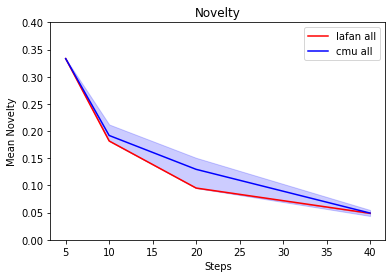

In [98]:
lafan_x = []
lafan_y = []

cmu_x = []
cmu_y = []

for _, row in novelty_summary.iterrows():
  if row['dataset'] == 'lafan':
    lafan_x.append(row['steps'])
    lafan_y.append(row['mean'])
  if row['dataset'] == 'cmu':
    cmu_x.append(row['steps'])
    cmu_y.append(row['mean'])

label = f'lafan all'
sns.lineplot(lafan_x, lafan_y, label=label, 
              color=graph_line_settings[label])
label = f'cmu all'
sns.lineplot(cmu_x, cmu_y, label=label, 
              color=graph_line_settings[label])
plt.ylim(0, 0.4);

plt.title('Novelty')
plt.xlabel('Steps')
plt.ylabel('Mean Novelty');